## Miscellaneous Imports

In [2]:
import pandas as pd
import numpy as np

# Truncate Data

As the data has 6.4 million rows, we truncated the data by randomly sampling 200000 rows, stratified by review score.

In [8]:
def truncate(df: pd.DataFrame, target_col: str, n: int) -> pd.DataFrame:
    return df.groupby(target_col).apply(lambda x: x.sample(n=n//2)).droplevel(0)

def df_to_csv(df:pd.DataFrame, path:str):
    import csv
    df.to_csv(path, index=False, quoting=csv.QUOTE_NONNUMERIC)

# df = pd.read_csv('datasets/steam_dataset.csv')
# df = truncate(df, 'review_score', 200000)
# df_to_csv(df, 'datasets/steam_dataset_200000.csv')

# Clean Data

In [ ]:
def read_data_from_csv(file_path, column_text, column_score):
    """
    Read data from csv file. Select only the columns that are needed.

    Args:
    file_path: string
    column_text: string
    column_score: string
    """
    data = pd.read_csv(file_path)
    data[column_text] = data[column_text].astype(str)
    data[column_score] = data[column_score].astype(int)
    return data

def preprocess(text):
    """
    Preprocess text: Convert a sentence into a tokenised list of words.

    Args:
    text: string
    """
    from nltk.tokenize import word_tokenize
    import string
    # Convert text to lowercase
    text = text.lower()
    # Remove non-ascii characters and punctuation
    text = ''.join([word if (word not in string.punctuation or word.isascii()) else ' ' for word in text])
    # Tokenize text
    tokens = word_tokenize(text)
    return tokens

def clean_data(data, column_text, column_score, new_column_text='text', new_column_score='score'):
    """
    Clean data: Preprocess text and remove rows with missing values. Change column names.

    Args:
    data: pandas dataframe
    column_text: string
    column_score: string
    new_column_text: string
    new_column_score: string
    """

    data[column_text] = data[column_text].apply(preprocess)
    data = data.dropna()
    data = data[[column_text, column_score]]
    data = data.rename(columns={column_text: new_column_text, column_score: new_column_score})
    return data

# df = read_data_from_csv('datasets/steam_dataset_200000.csv', 'review_text', 'review_score')
# df = clean_data(df, 'review_text', 'review_score')
# df_to_csv(df, 'datasets/steam_200000_cleaned.csv')

# Stemming

In [4]:
def read_tokenized_csv(path: str, token_col: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df[token_col] = df[token_col].apply(lambda x: list(map(lambda s: s[1:-1], x[1:-1].split(', '))))
    return df

def stem_tokens(tokens, stemmer_option = "PorterStemmer"):
    """
    Stem tokens

    Args:
    tokens: list of tokens
    stemmer: 1 of the 3 stemmers provided by nltk
    """
    stemmer = None
    if stemmer_option == "PorterStemmer":
        from nltk.stem import PorterStemmer
        stemmer = PorterStemmer()
    elif stemmer_option == "LancasterStemmer":
        from nltk.stem import LancasterStemmer
        stemmer = LancasterStemmer()
    elif stemmer_option == "SnowballStemmer":
        from nltk.stem import SnowballStemmer
        stemmer = SnowballStemmer("english")
    return [stemmer.stem(token) for token in tokens]

def stem_data(data, column_text):
    data[column_text] = data[column_text].apply(stem_tokens)
    return data

# df = read_tokenized_csv('datasets/steam_200000_cleaned.csv', 'text')
# df = stem_data(df, 'text')
# df_to_csv(df, 'datasets/steam_200000_stemmed.csv')

# Word Embedding

In [ ]:
def identity(x):
    return x

def generate_sample_tfidf_model(data, column_text, max_features=500):
    """
    Generate a sample tfidf model
    """
    from sklearn.feature_extraction.text import TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(tokenizer=identity, lowercase=False, max_features=max_features)
    tfidf_vectorizer.fit(data[column_text].values)
    return tfidf_vectorizer

def save_pkl(model, file_path):
    """
    Save model to disk, end with .pkl
    """
    import joblib
    joblib.dump(model, file_path)

def load_pkl(file_path):
    """
    Load model from disk
    """
    import joblib
    return joblib.load(file_path)

def generate_sample_w2v_model(data, column_text, vector_size = 100):
    """
    Generate a sample word2vec model
    """
    from gensim.models import Word2Vec
    model = Word2Vec(data[column_text], min_count=1, window=8, workers=100, vector_size=vector_size)
    return model

def save_gensim(model, file_path):
    """
    Save model to disk
    """
    model.save(file_path)

def load_gensim(file_path):
    """
    Load model from disk
    """
    from gensim.models import Word2Vec
    word_embedding_model = Word2Vec.load(file_path)
    return word_embedding_model

# df = read_tokenized_csv('datasets/steam_200000_stemmed.csv', 'text')

# tfidf_vectorizer = generate_sample_tfidf_model(df, 'text')
# save_pkl(tfidf_vectorizer, 'datasets/tfidf_vectorizer.pkl')

# word_embedding_model = generate_sample_w2v_model(df, 'text')
# save_gensim(word_embedding_model, 'datasets/word_embedding_model')

# Transform Data

In [13]:
def transform_tfidf(data, column_text, column_score, tfidf_vectorizer):
    """
    Transform data into tfidf vectors

    Args:
    data: pandas dataframe
    column_text: string
    column_score: string
    tfidf_vectorizer: TfidfVectorizer
    """
    tfidf = tfidf_vectorizer.transform(data[column_text].values)
    tfidf_df = pd.DataFrame(tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    tfidf_df[column_score] = data[column_score]
    return tfidf_df

def transform_w2v(data, column_text, word_embedding_model_arg):
    """
    Transform data into word embeddings

    Args:
    data: pandas dataframe
    column_text: string
    word_embedding_model: word embedding model
    """
    vector_size = word_embedding_model_arg.vector_size
    apply_word_embedding = lambda x: [word_embedding_model_arg.wv[word] for word in x if word in word_embedding_model_arg.wv]
    apply_mean = lambda x: np.mean(x, axis=0) if len(x) > 0 else np.zeros(vector_size)
    data[column_text] = data[column_text].apply(apply_word_embedding).apply(apply_mean)
    expanded = pd.DataFrame(data[column_text].to_list(), columns=list(range(vector_size)))
    data = pd.concat([expanded, data], axis=1)
    data.drop(columns=[column_text], inplace=True)
    return data

# df = read_tokenized_csv('datasets/steam_200000_stemmed.csv', 'text')
# tfidf_vectorizer = load_pkl('datasets/tfidf_vectorizer.pkl')
# tfidf_df = transform_tfidf(df, 'text', 'score', tfidf_vectorizer)
# df_to_csv(tfidf_df, 'datasets/steam_200000_tfidf.csv')

# word_embedding_model = load_gensim("datasets/word_embedding_model")
# w2v_df = transform_w2v(df, 'text', word_embedding_model)
# df_to_csv(w2v_df, 'datasets/steam_200000_w2v.csv')

# Exploratory Data Analysis

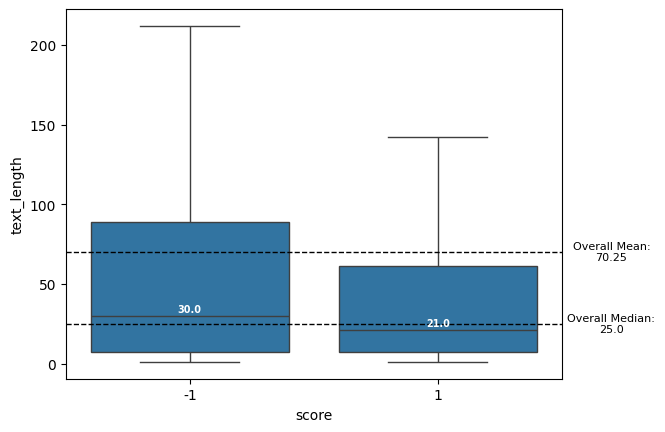

In [14]:
def generate_length_boxplot(df_stemmed: pd.DataFrame, col_text: str, col_score: str):

    from matplotlib import pyplot as plt
    import seaborn as sns

    df_stemmed['text_length'] = df_stemmed[col_text].apply(len)
    box_plot = sns.boxplot(data=df_stemmed, x=col_score, y='text_length', showfliers=False)

    medians = df_stemmed.groupby([col_score])['text_length'].median()
    vertical_offset = df_stemmed['text_length'].median() * 0.1

    for score in (-1, 1):
        box_plot.text(int(score>0), medians[score] + vertical_offset, medians[score],
                      horizontalalignment='center',size='x-small',color='w',weight='semibold')

    overall_median = df_stemmed['text_length'].median()
    box_plot.axhline(overall_median, color='black', linestyle='--', lw=1)
    plt.text(1.7, overall_median, f'Overall Median:\n{overall_median}', horizontalalignment='center', verticalalignment='center', fontsize=8)

    overall_mean = round(df_stemmed['text_length'].mean(), 2)
    box_plot.axhline(overall_mean, color='black', linestyle='--', lw=1)
    plt.text(1.7, overall_mean, f'Overall Mean:\n{overall_mean}', horizontalalignment='center', verticalalignment='center', fontsize=8)

    plt.show()

df_stemmed = read_tokenized_csv('datasets/steam_200000_stemmed.csv', 'text')
generate_length_boxplot(df_stemmed, 'text', 'score')

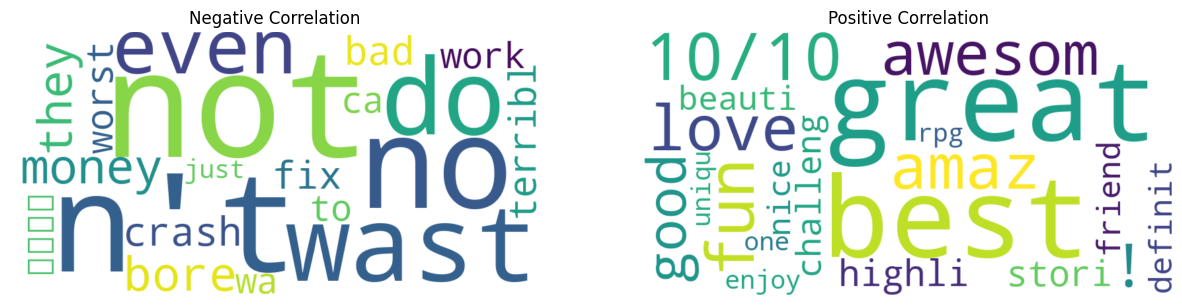

In [15]:
def generate_wordcloud(tfidf_df: pd.DataFrame, col_score: str, N: int):

    from matplotlib import pyplot as plt
    from wordcloud import WordCloud

    correlation = tfidf_df.drop(columns=[col_score]).corrwith(tfidf_df[col_score])

    neg_corr = -correlation[correlation < 0]
    pos_corr = correlation[correlation > 0]

    high_neg = neg_corr.nlargest(N)
    high_pos = pos_corr.nlargest(N)

    negative_wordcloud_data = {token: corr for token, corr in high_neg.items()}
    positive_wordcloud_data = {token: corr for token, corr in high_pos.items()}

    negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(negative_wordcloud_data)
    positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_wordcloud_data)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(negative_wordcloud, interpolation='bilinear')
    plt.title('Negative Correlation')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(positive_wordcloud, interpolation='bilinear')
    plt.title('Positive Correlation')
    plt.axis('off')

    plt.show()

tfidf_df = pd.read_csv('datasets/steam_200000_tfidf.csv')
generate_wordcloud(tfidf_df, 'score', 20)